<a href="https://colab.research.google.com/github/StevenMena/05MIAR---Aprendizaje_Supervisado/blob/main/Actividad_Portfolio_Victor_Pinargote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Cargar una de las imágenes histológicas

In [ ]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
# Recuerda normalizar la imagen diviéndola entre 255


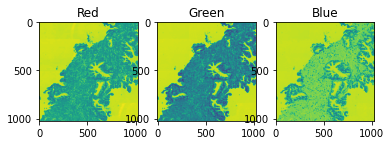

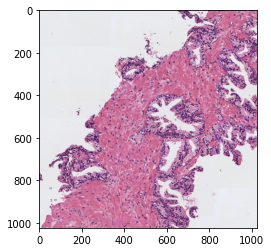

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2

histo_1 = io.imread('histo_1.jpg')
img = histo_1/255

R = img[:,:,2]
G = img[:,:,1]
B = img[:,:,0]

fig, ax = plt.subplots(1,3)
ax[0].imshow(R), ax[0].set_title('Red')
ax[1].imshow(G), ax[1].set_title('Green')
ax[2].imshow(B), ax[2].set_title('Blue')
plt.show()
plt.imshow(img, cmap='gray')


In [ ]:
np.shape(img)

(1024, 1024, 3)

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [ ]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)
# 2) Visualiza la imagen con la librería de matplotlib. 
# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"


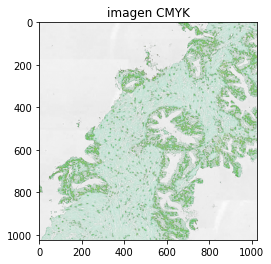

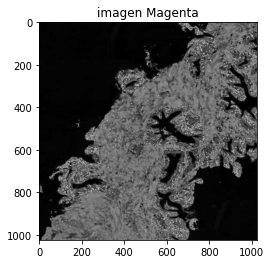

True

In [ ]:
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img, axis=2)
    C = (1-img[...,0] - K)/(1-K)
    M = (1-img[...,1] - K)/(1-K)
    Y = (1-img[...,2] - K)/(1-K)

CMYK = (np.dstack((C,M,Y,K)))
Y, M, C, K = cv2.split(CMYK)

plt.title('imagen CMYK')
plt.imshow(CMYK, cmap='gray')
plt.show()
plt.title('imagen Magenta')
plt.imshow(M, cmap='gray')
plt.show()

cv2.imwrite('1_imagen_magenta.png', M)

In [ ]:
np.shape(M)

(1024, 1024)

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# 1) Convierte la imagen Magenta a formato "uint8"
# 2) Aplica un filtro gaussiano de tamaño 5x5
# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 
# 5) Visualiza la máscara resultante (imagen de 0s y 1s)
# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"


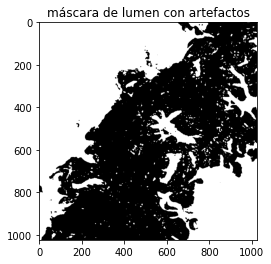

True

In [ ]:
M *= 255
M = np.asarray(M, np.uint8)
blur = cv2.GaussianBlur(M,(5,5),0) #2
th, im_th = cv2.threshold(blur,0,255,cv2.THRESH_OTSU) #3
lumen_mask=im_th==0 #4
lumen_mask = np.uint8(lumen_mask)
plt.imshow(lumen_mask, cmap='gray') #5
plt.title('máscara de lumen con artefactos')
plt.show()
cv2.imwrite('2_mascara_con_artefactos.png', lumen_mask*255) #6


#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects. 
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.
# 2) Convierte la máscara generada en formato uint8
# 3) Visualiza la máscara resultante
# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"


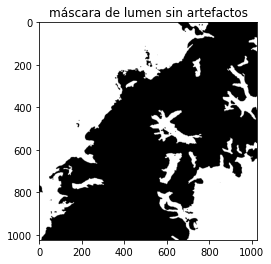

True

In [ ]:
from skimage.morphology import remove_small_objects as rso

cleaned_lumen = rso(lumen_mask.astype(bool), min_size=300, connectivity=8) #1
cleaned_lumen = np.uint8(cleaned_lumen) #2
plt.imshow(cleaned_lumen, cmap='gray') #3
plt.title('máscara de lumen sin artefactos')
plt.show()
cv2.imwrite('3_mascara_sin_artefactos.png', cleaned_lumen*255) #4

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# 1) Aplica el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.
# 2) Visualiza la máscara resultante
# 3) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"


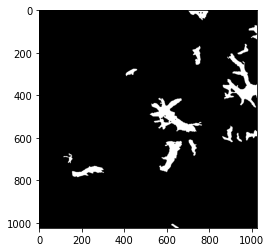

True

In [ ]:
semi_lumen = cleaned_lumen.copy()
h, w = semi_lumen.shape #2
ref = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(semi_lumen, ref, (0,0), 0)
cv2.floodFill(semi_lumen, ref, (h-1,w-1), 0)
## Adicional
semi_lumen = rso(semi_lumen.astype(bool), min_size=300, connectivity=8)
semi_lumen = np.uint8(semi_lumen)
plt.imshow(semi_lumen, cmap='gray') #3
plt.show()
cv2.imwrite('4_mascara_lumenes.png', semi_lumen*255) #4


#### Rellenar los objetos de los lúmenes

In [ ]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
# 3) Visualiza la máscara
# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"


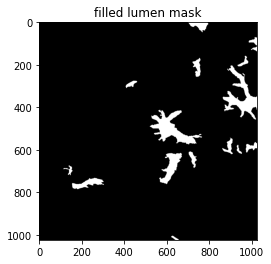

True

In [ ]:
from scipy.ndimage.morphology import binary_fill_holes as bfh
filled_lumen = bfh(semi_lumen) #1
filled_lumen = np.uint8(filled_lumen) #2
plt.imshow(filled_lumen, cmap='gray') #3
plt.title('filled lumen mask')
plt.show()
cv2.imwrite('5_mascara_final.png', filled_lumen*255) #4

#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# 1) Encuentra los contornos de los lúmenes
# 2) Dibuja los contornos (de color verde) sobre la imagen original
# 3) Visualiza la imagen superpuesta
# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"


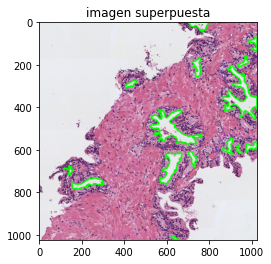

True

In [ ]:
conts,_ = cv2.findContours(filled_lumen, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #1
overlapped = cv2.drawContours(img, conts, -1, (0,255,0), 5) #2
plt.imshow(overlapped, cmap='gray') #3
plt.title('imagen superpuesta')
plt.show()
cv2.imwrite('6_imagen_superpuesta.png', overlapped*255) # 4

#### Identificar y cropear el lumen más grande

In [ ]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
# 2) Calcula el área de cada uno de los lúmenes 
# 3) Obtén una máscara del lumen de mayor área
# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box
# 5) Visualiza la máscara recortada del lumen
# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"


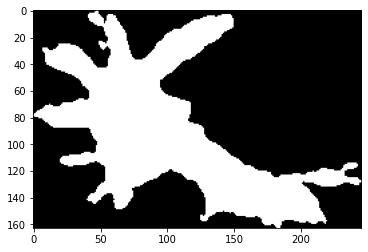

True

In [ ]:
# Vamos a extraer diferentes descriptores geométricos que nos ayudarán a caracterizar los objetos.
# pip install tabulate
from skimage.measure import regionprops
from skimage.measure import label
lab, num = label(filled_lumen, return_num=True) #1
area=[] #2
for i in range(1,num+1):
  mask = lab == i
  prop = regionprops(mask.astype(np.uint8))
  area.append(prop[0].area)
pos = area.index(np.max(area)) #3
mask = lab == pos+1
prop = regionprops(mask.astype(np.uint8)) #4
bb = prop[0].bbox
crop = mask[bb[0]:bb[2],bb[1]:bb[3]]
plt.imshow(crop, cmap='gray') #5
plt.show()
cv2.imwrite('7_crop_image.png', crop*255) #6

In [ ]:
bb

(412, 520, 575, 766)

#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [ ]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad


In [ ]:
# Extraemos las característicias geométricas
import math
from tabulate import tabulate

headers = ['','Mas Grande','Mas Grande']
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['Área:'], ['Bbox área'], ['Área convexa'], ['Excentricidad'], ['Diámetro equivalente:'], \
['Extensión'], ['Longitud del eje mayor'], ['Longitud del eje menor'], ['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad'], ['Rectangularidad']

prop = regionprops(crop.astype(np.uint8))
    
A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers))

                          Mas Grande
----------------------  ------------
Área:                     14075
Bbox área                 40098
Área convexa              29283
Excentricidad                 0.8478
Diámetro equivalente:       133.869
Extensión                     0.351
Longitud del eje mayor      238.636
Longitud del eje menor      126.549
Orientación                   1.0058
Perímetro                  1242.6
Solidez                       0.4807
Compacidad                    0.1146
Rectangularidad               0.351
